In [7]:
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
import pandas as pd

# Load MNIST dataset
mnist = fetch_openml('mnist_784')

# Split the data into features (X) and labels (y)
X = mnist.data
y = mnist.target
# Split the data into training and testing sets
X_test = X[-10000:].reset_index(drop=True)  # Reset the indices to avoid errors
y_test = y[-10000:].reset_index(drop=True)
X_train = X[:-10000]
y_train = y[:-10000]

# Convert the data and target to a DataFrame
df = pd.DataFrame(X_train)
df['target'] = y_train

# Create a dictionary of DataFrames, each corresponding to a unique digit
groups = {digit: data for digit, data in df.groupby('target', observed=False)}

# Initialize an empty DataFrame for the final training set
rows, cols = df.drop('target', axis=1).shape
final_train_set = pd.DataFrame()
kmeans = KMeans(n_clusters=9)

# For each group, sample 9 digits and append to the final training set
for digit, data in groups.items():
    
    kmeans.fit(data.drop('target', axis=1))
    means = pd.DataFrame(kmeans.cluster_centers_)
    means['target'] = digit
    final_train_set = pd.concat([final_train_set, means], ignore_index=True)

# Split the final training set into features (X) and labels (y)
X_train_approx = final_train_set.drop('target', axis=1)
y_train_approx = final_train_set['target']


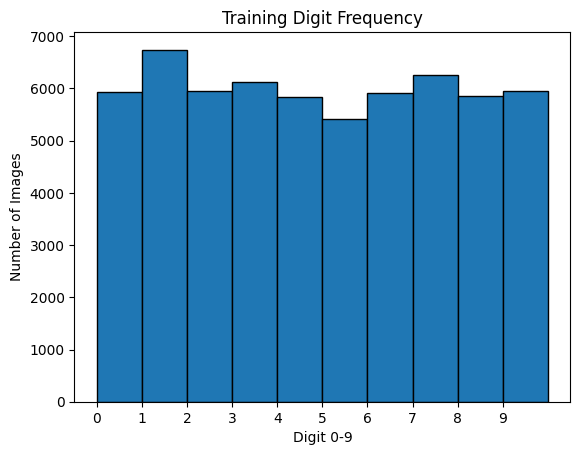

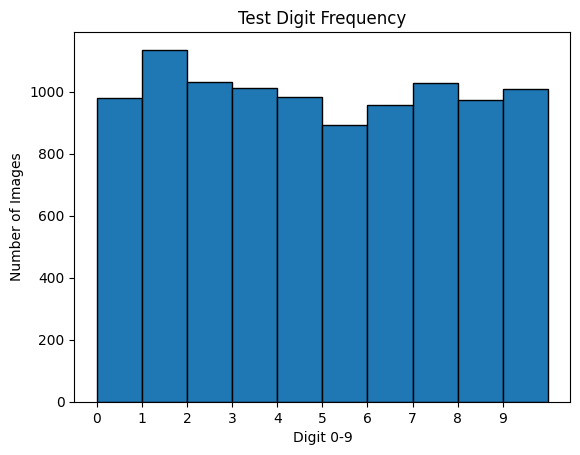

In [8]:
import matplotlib.pyplot as plt

# Convert the target and prediction columns to integers to avoid errors
y_train = y_train.astype(int) 
y_test = y_test.astype(int)

# Create a histogram of the digit frequency in the training dataset
plt.hist(y_train, bins=10, range=(0,10), edgecolor='black')
plt.title('Training Digit Frequency')
plt.xlabel('Digit 0-9')
plt.ylabel('Number of Images')
plt.xticks(range(10))
plt.show()

# Create a histogram of the digit frequency in the test dataset
plt.hist(y_test, bins=10, range=(0,10), edgecolor='black')
plt.title('Test Digit Frequency')
plt.xlabel('Digit 0-9')
plt.ylabel('Number of Images')
plt.xticks(range(10))
plt.show()


In [9]:
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import time

knn = KNeighborsClassifier(n_neighbors=1)


# Create a DataFrame with feature and target training values
classifier_dict = {feature: X_test[feature] for feature in mnist.feature_names}
classifier_dict['target'] = y_test
classifier_df = pd.DataFrame(classifier_dict)

knn.fit(X_train_approx, y_train_approx)   # Fit the classifier to the training data

# Calculate the prediction time in seconds and add to the DataFrame
start_time = time.time()
y_pred = knn.predict(X_test)    # Predict the test data
end_time = time.time()
prediction_time = (end_time - start_time).__round__(2)  
classifier_df['prediction'] = y_pred    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


/var/folders/n4/_628flvn3t96dj4flkfjwt6r0000gq/T/ipykernel_374/1484592712.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[i,j].set_title('digit ' + str(row_identifiers[-2]) + ' cluster ' + str(row_identifiers[-1]))


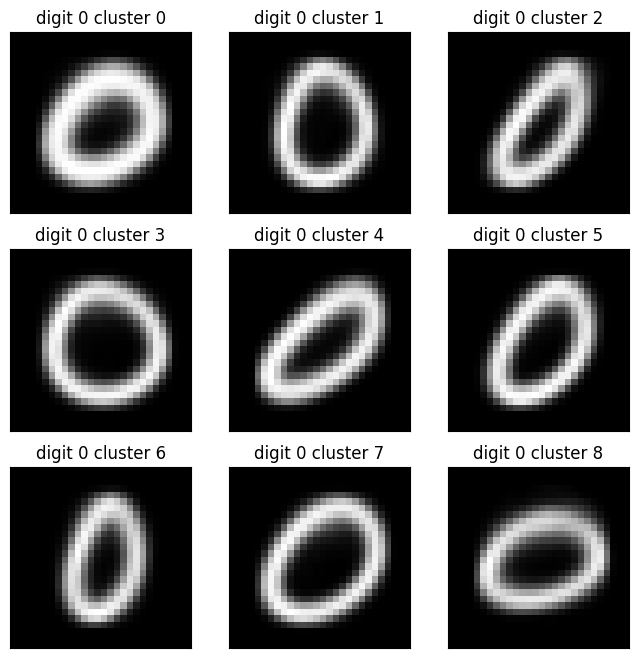

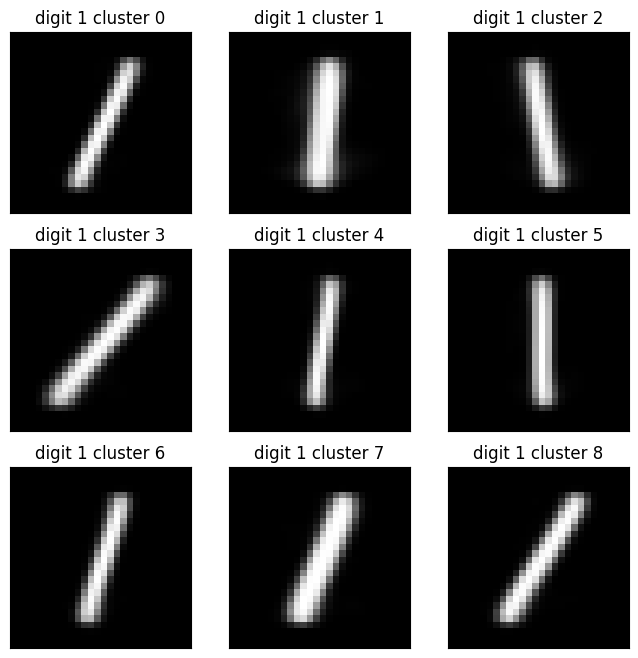

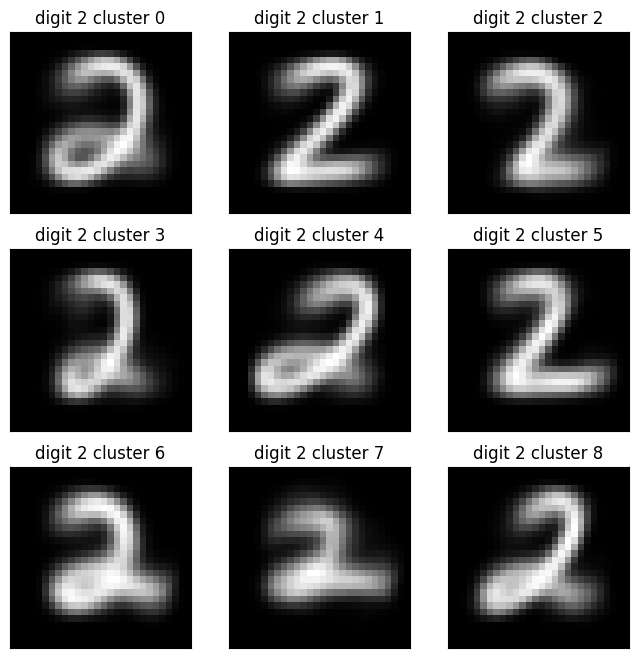

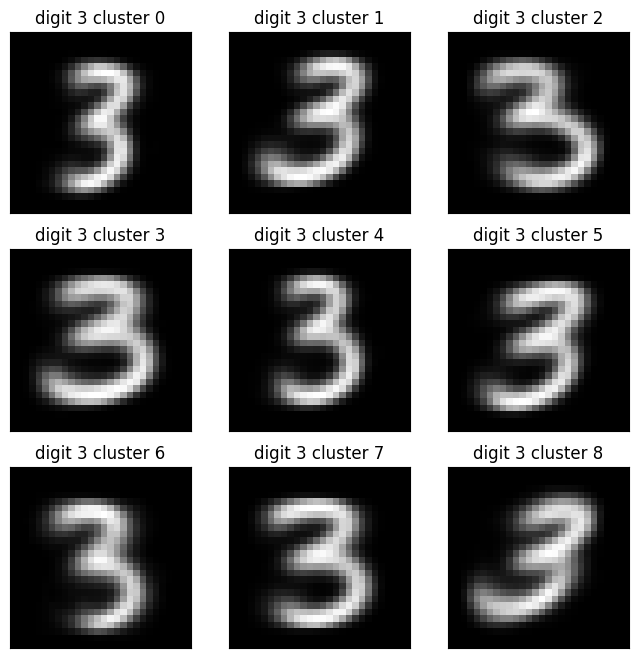

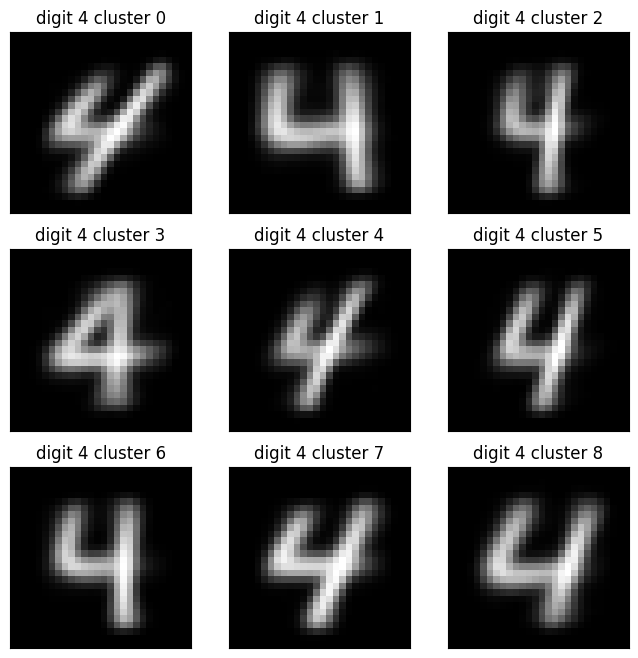

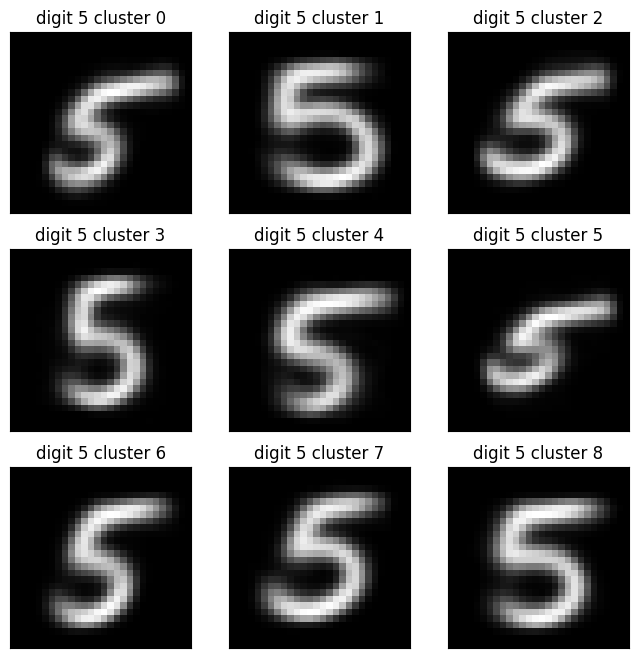

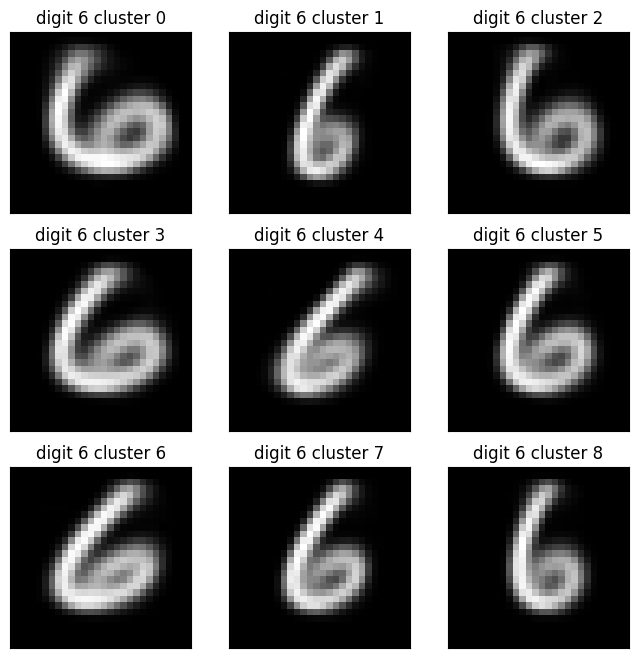

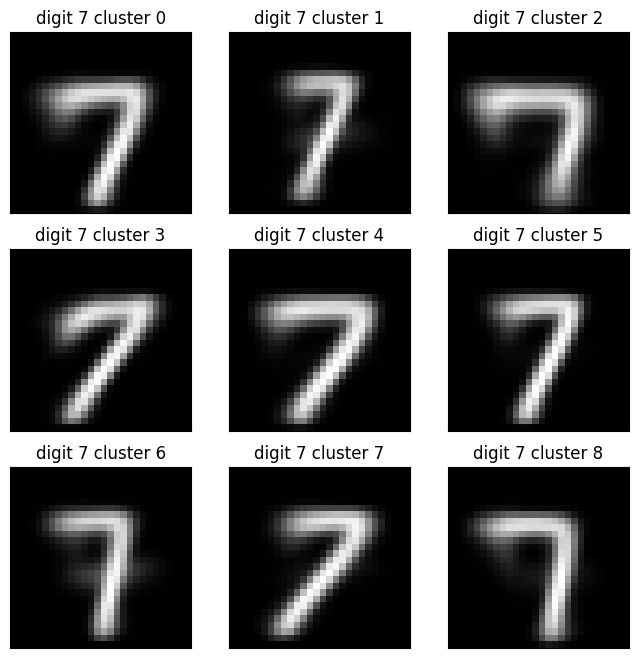

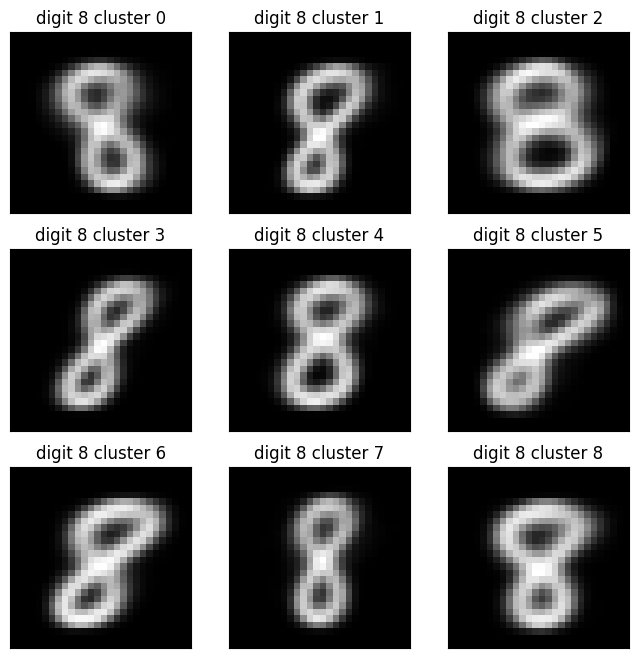

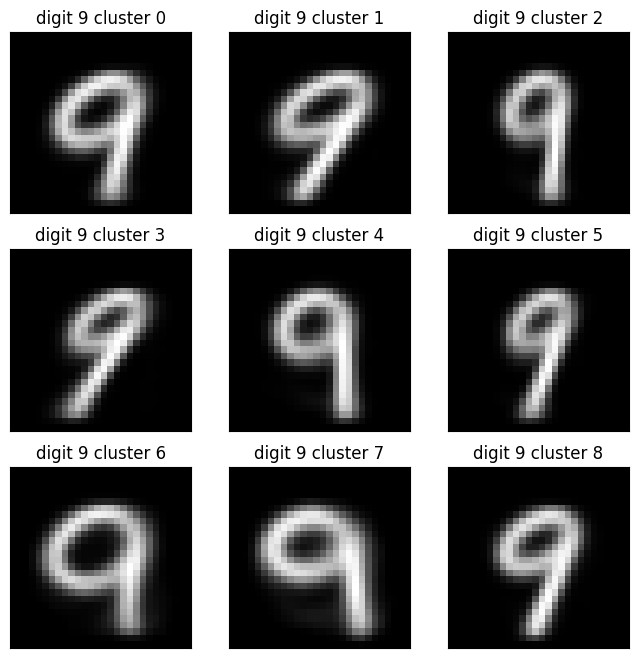

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Create a version of the data with a labeled clusters column for specific purposes
final_train_set_clusters = final_train_set.copy()
arr = np.arange(9)
rep_arr = np.tile(arr, 10)
final_train_set_clusters['clusters'] = rep_arr

# Create a 3x3 grid of images for each digit and cluster
groups = final_train_set_clusters.groupby('target')
for digit, data in groups:
    fig, ax = plt.subplots(3, 3, figsize=(8,8), )
    i = j = 0
    for row in data.iterrows():
        row_features = row[1][:-2]  # Exclude the target and cluster columns
        row_identifiers = row[1][-2:]   # Include only the target and cluster columns
        img = pd.to_numeric(row_features).values.reshape(28, 28)
        ax[i,j].imshow(img, cmap='gray')
        ax[i,j].set_xticks([]) 
        ax[i,j].set_yticks([]) 
        ax[i,j].set_title('digit ' + str(row_identifiers[-2]) + ' cluster ' + str(row_identifiers[-1]))
        
        # Increment the row and column counters
        j+=1
        if j == 3:
            j = 0
            i += 1
    plt.show()

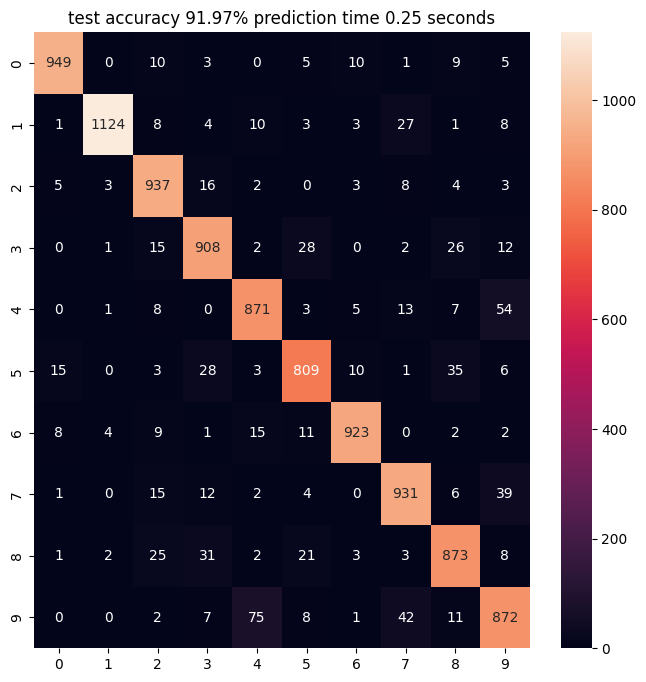

In [11]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

y_pred = y_pred.astype(int) # Convert the prediction column to integers to avoid errors

my_confusion_matrix = confusion_matrix(y_pred, y_test)
accuracy = my_confusion_matrix.diagonal().sum() / my_confusion_matrix.sum() * 100

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8,8))
plt.title('test accuracy ' + str(accuracy) + '% prediction time ' + str(prediction_time) + ' seconds')
plt.xlabel('true')
plt.ylabel('predicted')
sn.heatmap(my_confusion_matrix, annot=True, fmt='.4g')
plt.show()



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


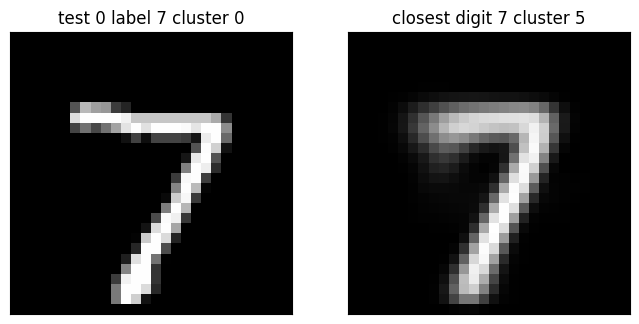

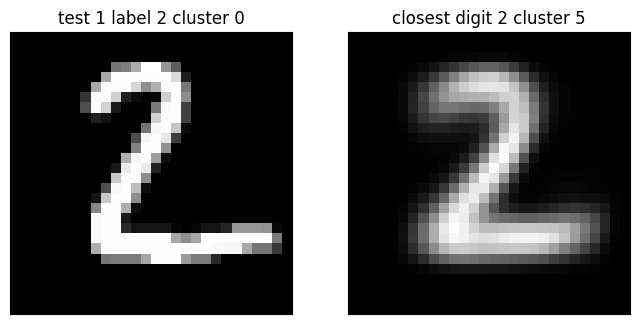

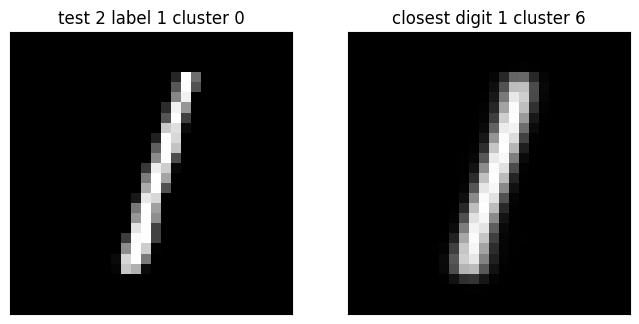

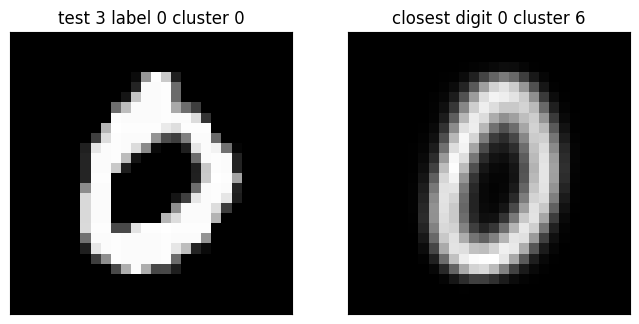

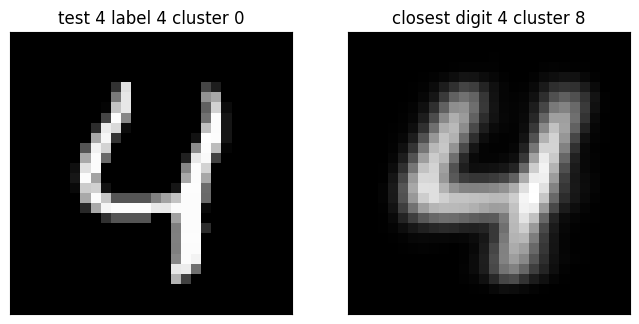

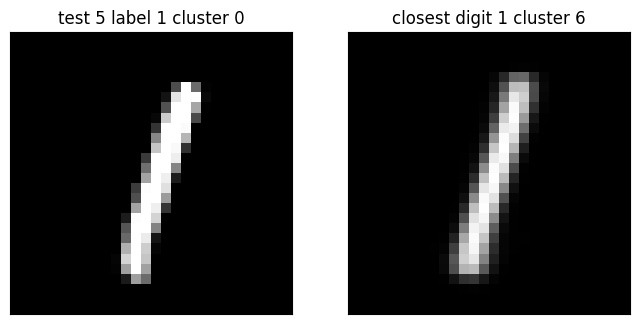

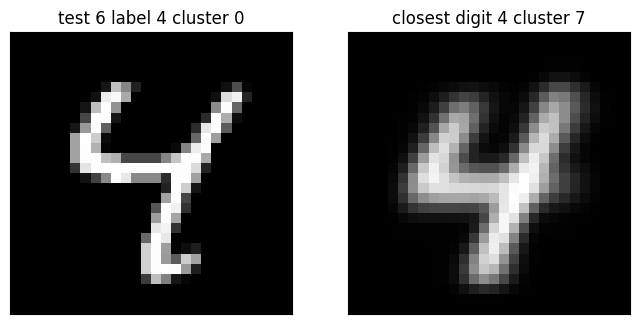

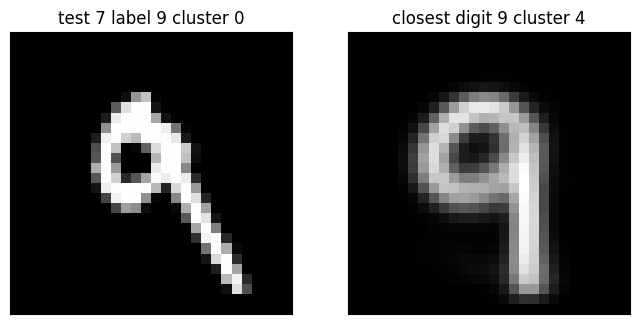

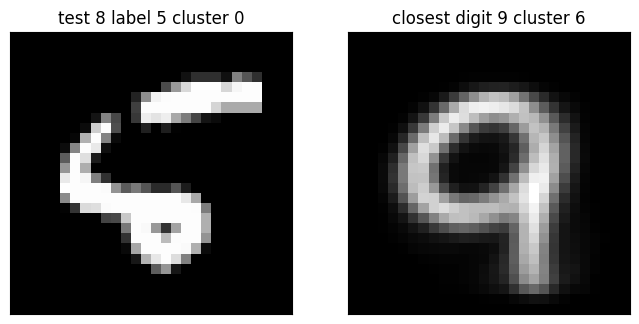

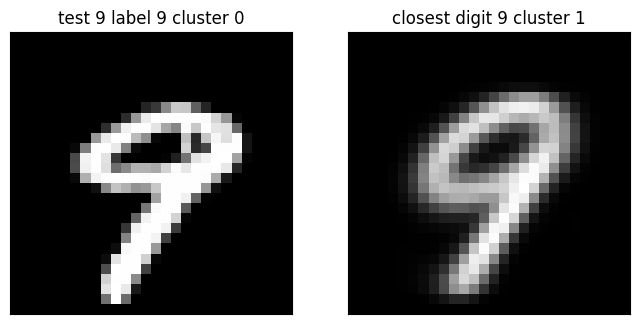

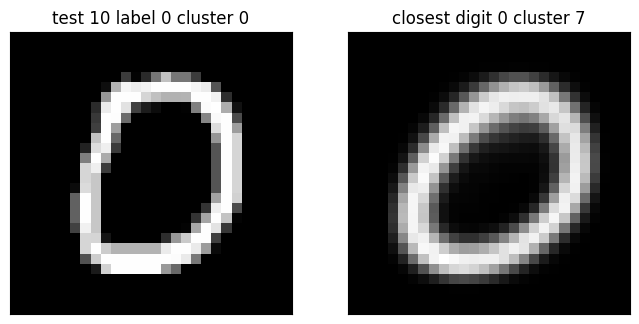

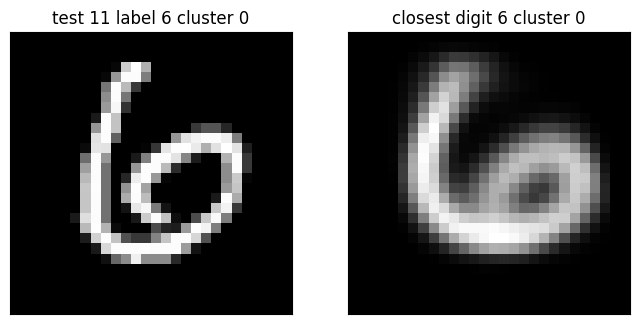

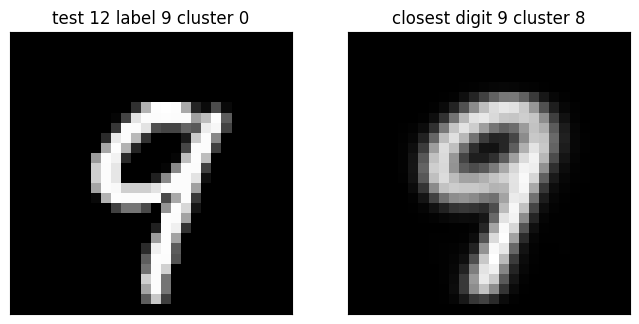

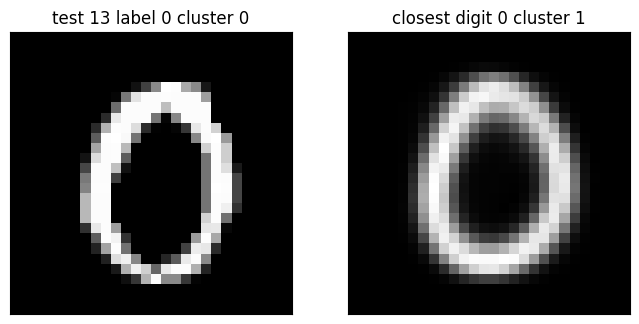

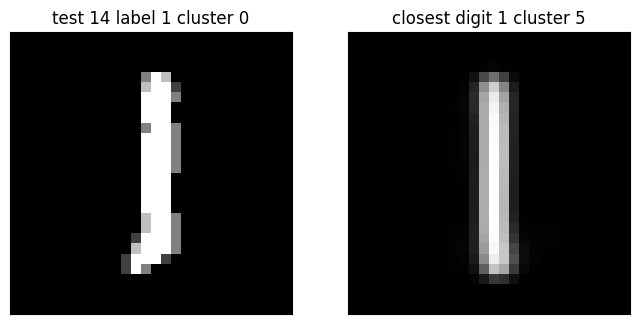

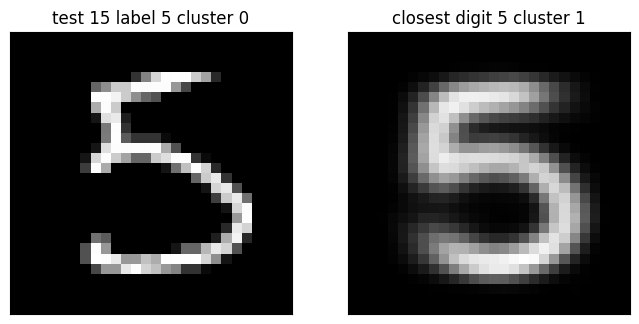

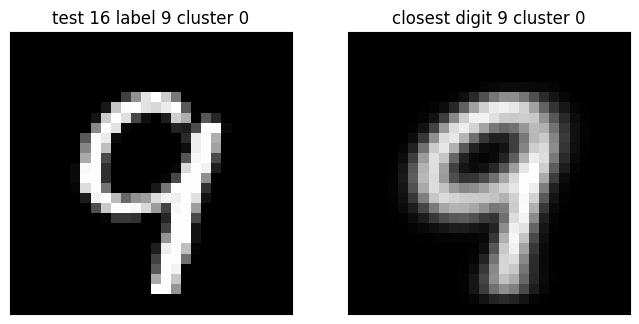

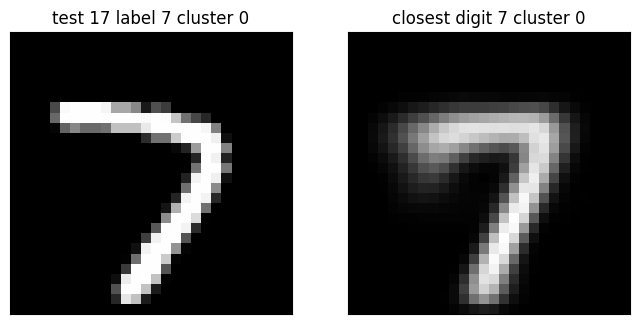

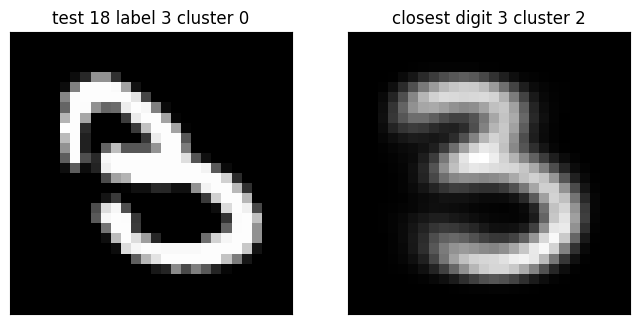

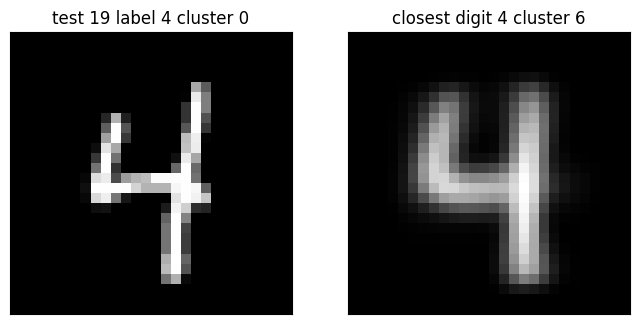

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Identify the nearest cluster to each test digit for the first 20 test digits
distances, indices = knn.kneighbors(X_test[:20])
nearest_clusters_indices = indices[:, 0]

# Create a DataFrame of the nearest clusters data according to the identified indices
nearest_clusters = final_train_set.iloc[nearest_clusters_indices].drop('target', axis=1)

rows = 20

# Create a 1x2 grid of images for each test digit and its nearest cluster
for i in range(rows):
    # Plot the test digit image
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    img = pd.to_numeric(X_test.iloc[i, :]).values.reshape(28, 28)
    ax[0].imshow(img, cmap='gray')
    ax[0].set_xticks([]) 
    ax[0].set_yticks([]) 
    ax[0].set_title('test ' + str(i) + ' label ' + str(y_test[i]) + ' cluster ' + str(X_test.iloc[nearest_clusters_indices[i], -1]))

    # Plot the nearest cluster image
    img = pd.to_numeric(nearest_clusters.iloc[i, :]).values.reshape(28, 28)
    ax[1].imshow(img, cmap='gray')
    ax[1].set_xticks([]) 
    ax[1].set_yticks([]) 
    ax[1].set_title('closest digit ' + str(y_pred[i]) + ' cluster ' + str(final_train_set_clusters.iloc[nearest_clusters_indices[i], -1]))
    plt.show()
    